# Spleen Segmentation using Attention U-Net



## Introduction

This project explores the application of deep learning techniques for **medical image segmentation**, specifically targeting the **spleen** in 3D CT scans. Accurate organ segmentation is a critical step in many clinical workflows, including diagnosis, surgical planning, and disease monitoring.

To address this task, we use the **Spleen dataset (Task09_Spleen)** from the [Medical Segmentation Decathlon](http://medicaldecathlon.com/), which provides annotated CT volumes for supervised training.

We implement an advanced architecture called the **Attention U-Net**, which builds upon the traditional U-Net by introducing **attention gates**. These modules enable the model to focus more effectively on relevant spatial features, improving segmentation performance in challenging medical images.

The notebook includes the following components:
-  Dataset loading and preprocessing
-  Attention U-Net architecture definition
-  Model training and evaluation
-  Visualization of segmentation results

By the end of this project, we demonstrate how attention mechanisms enhance feature selection and improve accuracy in biomedical segmentation tasks.


![SPLEEN SEGMENTATION DIAGRAM.png](<attachment:SPLEEN SEGMENTATION DIAGRAM.png>)
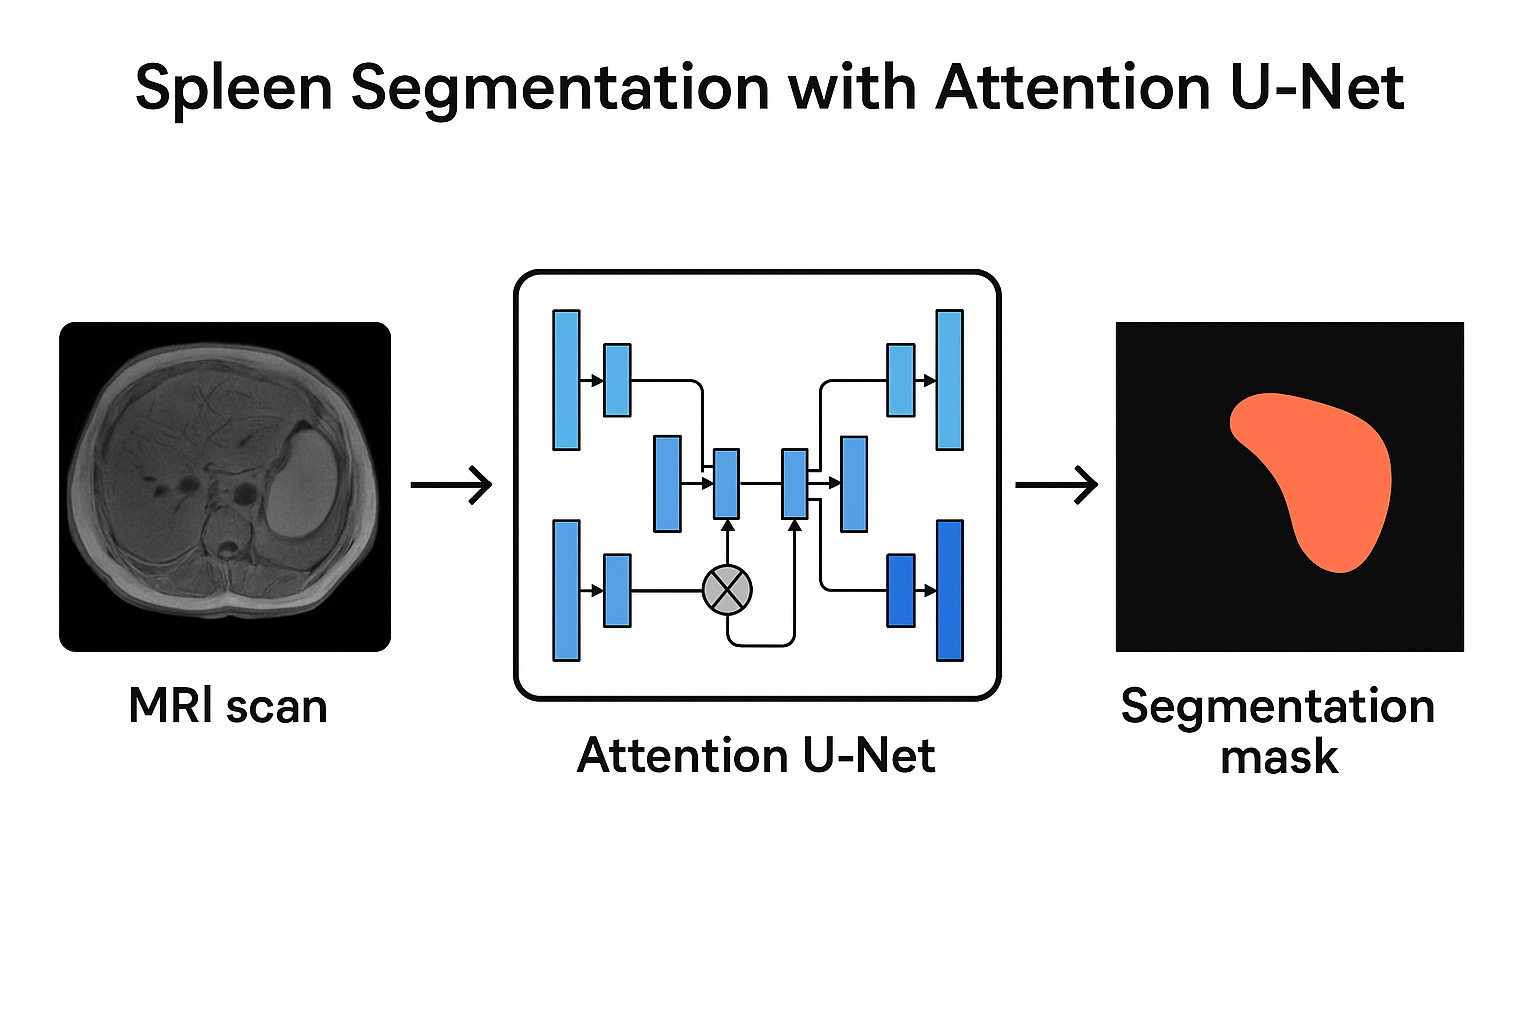

## 1. Data Handling

- **Libraries**: `nibabel`, `OpenCV`, `TensorFlow`, `NumPy`
- **Input format**: NIfTI medical imaging (`.nii.gz`)
- **Preprocessing**:
  - Normalization: Each image is scaled to [0, 1].
  - Slicing: 3D volumes are sliced along the axial plane (z-axis).
  - Resizing: 2D slices are resized to 128x128 pixels.
  - Label binarization: All non-zero labels are considered foreground (spleen).

## 2. Model: Attention U-Net

- Implements an **Attention U-Net**, which is an enhancement over traditional U-Net by using **attention gates**.
- The network:
  - Encoder: Downsampling path with convolution, batch norm, and max pooling.
  - Decoder: Upsampling path using transposed convolutions and attention blocks.
  - Attention Gate: Filters irrelevant features before concatenation in skip connections.
- Uses `sigmoid` activation at output for binary segmentation and `binary_crossentropy` loss.

## 3. Training

- Loss function: `Binary Crossentropy`
- Optimizer: `Adam`
- Metrics: Custom Intersection over Union (IoU)
- Uses `ModelCheckpoint` to save the best model.
- Epochs: 30
- Batch Size: 8

## 4. Evaluation

- Evaluates using **Thresholded Mean IoU**, measuring overlap between prediction and ground truth.
- Visual results suggest good spleen segmentation performance.

## 5. Visualization / Results

- Sample predictions are visualized using `matplotlib`:
  - Original image
  - Ground truth mask
  - Predicted mask
- Shows strong overlap with ground truth in most slices.




![Spleen diagram.png](<attachment:Spleen diagram.png>)
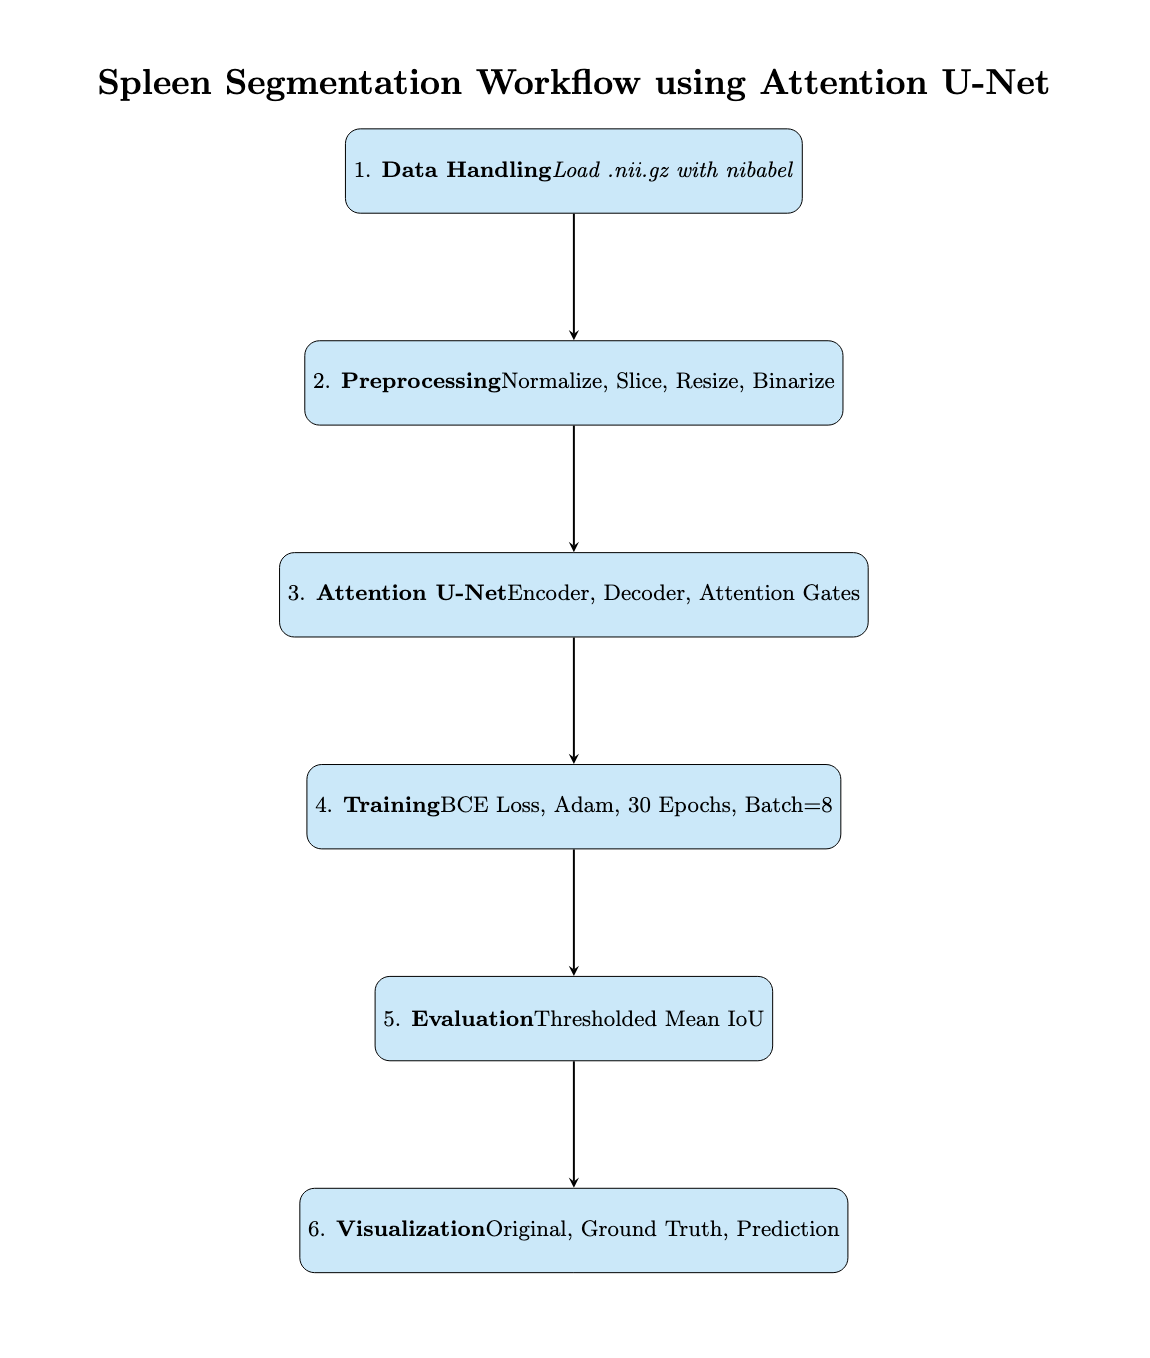

#  Dataset Description

### Introduction
This project uses the **Spleen dataset** from the [Medical Segmentation Decathlon](http://medicaldecathlon.com/), specifically designed for organ segmentation tasks using 3D medical imaging data.

###  Data Structure
- **Image Modality**: 3D CT (Computed Tomography) scans
- **File Format**: `.nii.gz` (NIfTI)
- **Directories**:
  - `imagesTr/`: Contains training images
  - `labelsTr/`: Contains corresponding ground truth segmentation masks

###  Segmentation Task
- **Objective**: Binary segmentation of the **spleen**
  - **Label 0**: Background
  - **Label 1**: Spleen
- Labels are thresholded during preprocessing to produce binary masks.

###  Preprocessing Pipeline
- Convert 3D volumes to 2D axial slices.
- Normalize intensity values to [0, 1].
- Resize all slices to **128 × 128** pixels.
- Add a channel dimension for grayscale compatibility with the model.

###  Dataset Size
- ~41 CT volumes for training.
- After slicing, the dataset expands to several hundred 2D samples.

###  Citation
> Simpson, A.L., Antonelli, M., Bakas, S., et al. (2019). *A large annotated medical image dataset for the development and evaluation of segmentation algorithms.* [arXiv:1902.09063](https://arxiv.org/abs/1902.09063)



### 1. DATA HANDLING
#### 1.1 Import libraries and check for GPU
Import all necessary libraries for image processing, model building, and visualization.


In [ ]:
# Required libraries
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras import layers, models, losses, metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

# Check for GPU (but you're on Intel CPU, so just informative)
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

2025-04-28 01:07:55.409379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Available GPUs: []


### 2. DATA PREPARATION
#### 2.1 Define paths and load NIfTI images
Set the paths to the training image and label folders from the Medical Segmentation Decathlon.


In [4]:
# Define paths (adjust if necessary)
image_dir = 'Task09_Spleen/imagesTr'
label_dir = 'Task09_Spleen/labelsTr'

# Load NIfTI files
def load_nifti_image(filepath):
    nifti = nib.load(filepath)
    return nifti.get_fdata()


#### 2.2 Preprocess images (normalize, resize, slice)

##### Why Resize to 128×128?

The original CT slices vary in size and are often high-resolution, which can be computationally expensive to process. To make training more efficient and manageable:

- We resize all slices to a fixed resolution of **128 × 128 pixels**.
- This ensures consistent input size for the neural network.
- It significantly reduces **memory usage** and **training time**.
- While downsampling does result in some loss of detail, 128×128 is generally sufficient to preserve essential structures like the spleen and surrounding anatomy.
- This size strikes a balance between **model performance** and **computational cost**.


In [5]:
# Resize and normalize
IMG_HEIGHT, IMG_WIDTH = 128, 128

def preprocess_image(image, label):
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    img_resized, lbl_resized = [], []
    for i in range(image.shape[2]):
        img_slice = cv2.resize(image[:, :, i], (IMG_WIDTH, IMG_HEIGHT))
        lbl_slice = cv2.resize(label[:, :, i], (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        img_resized.append(img_slice)
        lbl_resized.append(lbl_slice)
    return np.array(img_resized), np.array(lbl_resized)


#### 2.3 Load and preprocess full dataset, split into train/val
 Load NIfTI images, normalize intensity values, and extract 2D slices for both images and masks.


In [6]:
# Load and preprocess all dataset
X, Y = [], []
for fname in os.listdir(image_dir):
    if fname.endswith('.nii.gz'):
        img = load_nifti_image(os.path.join(image_dir, fname))
        lbl = load_nifti_image(os.path.join(label_dir, fname.replace('_0000', '')))
        img_slices, lbl_slices = preprocess_image(img, lbl)
        X.extend(img_slices)
        Y.extend(lbl_slices)

X = np.array(X)[..., np.newaxis]
Y = (np.array(Y) > 0).astype(np.float32)[..., np.newaxis]

# Train-validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data shapes:", X_train.shape, Y_train.shape)


Data shapes: (2920, 128, 128, 1) (2920, 128, 128, 1)


### 3. Model Architecture



# Attention U-Net Architecture – Explanation

The **Attention U-Net** is an enhanced version of the U-Net architecture for image segmentation. It introduces **attention gates** that allow the network to focus on relevant spatial regions, suppressing irrelevant feature activations. This is especially useful in medical image segmentation where the target region may be small and ambiguous.

---

##  1. Input
- **Input shape**: `(128, 128, 1)`  
- Represents a single-channel grayscale image slice from a 3D medical volume.

---

##  2. Encoder (Contracting Path)
The encoder reduces spatial resolution while increasing feature complexity.

- **Block 1:**
  - `Conv2D(32)` → ReLU → `Conv2D(32)` → ReLU
  - `MaxPooling2D(2x2)` → output shape: `(64, 64, 32)`

- **Block 2:**
  - `Conv2D(64)` → ReLU → `Conv2D(64)` → ReLU
  - `MaxPooling2D(2x2)` → output shape: `(32, 32, 64)`

- **Block 3:**
  - `Conv2D(128)` → ReLU → `Conv2D(128)` → ReLU
  - `MaxPooling2D(2x2)` → output shape: `(16, 16, 128)`

---

##  3. Bottleneck
- `Conv2D(256)` → ReLU → `Conv2D(256)` → ReLU  
- Captures high-level abstract features at the lowest resolution: `(16, 16, 256)`

---

##  4. Decoder (Expanding Path) with Attention Gates
The decoder upsamples and reconstructs the segmentation mask, using **attention gates** to filter encoder features.

- **Attention Gate**: Each encoder output is passed through an attention mechanism gated by the corresponding decoder features before concatenation.

- **Decoder Block 1:**
  - Attention on `c3` using `c4`
  - `UpSampling2D(2x2)` + Concatenate + `Conv2D(128)` ×2  
  - Output shape: `(32, 32, 128)`

- **Decoder Block 2:**
  - Attention on `c2` using `c5`
  - `UpSampling2D(2x2)` + Concatenate + `Conv2D(64)` ×2  
  - Output shape: `(64, 64, 64)`

- **Decoder Block 3:**
  - Attention on `c1` using `c6`
  - `UpSampling2D(2x2)` + Concatenate + `Conv2D(32)` ×2  
  - Output shape: `(128, 128, 32)`

---

##  5. Output Layer
- `Conv2D(1, 1x1)` with **sigmoid** activation  
- Produces a pixel-wise binary segmentation mask: `(128, 128, 1)`

---

##  Summary Table

| Stage        | Output Shape        | Filters | Description                     |
|--------------|---------------------|---------|---------------------------------|
| Input        | 128×128×1           | –       | Grayscale image slice           |
| Encoder 1    | 128×128×32          | 32      | Conv2D + MaxPooling             |
| Encoder 2    | 64×64×64            | 64      | Conv2D + MaxPooling             |
| Encoder 3    | 32×32×128           | 128     | Conv2D + MaxPooling             |
| Bottleneck   | 16×16×256           | 256     | Deepest features                |
| Decoder 1    | 32×32×128           | 128     | Attention + Upsample + Conv2D   |
| Decoder 2    | 64×64×64            | 64      | Attention + Upsample + Conv2D   |
| Decoder 3    | 128×128×32          | 32      | Attention + Upsample + Conv2D   |
| Output       | 128×128×1           | 1       | Segmentation mask (Sigmoid)     |

---



![diagram model.png](<attachment:diagram model.png>)
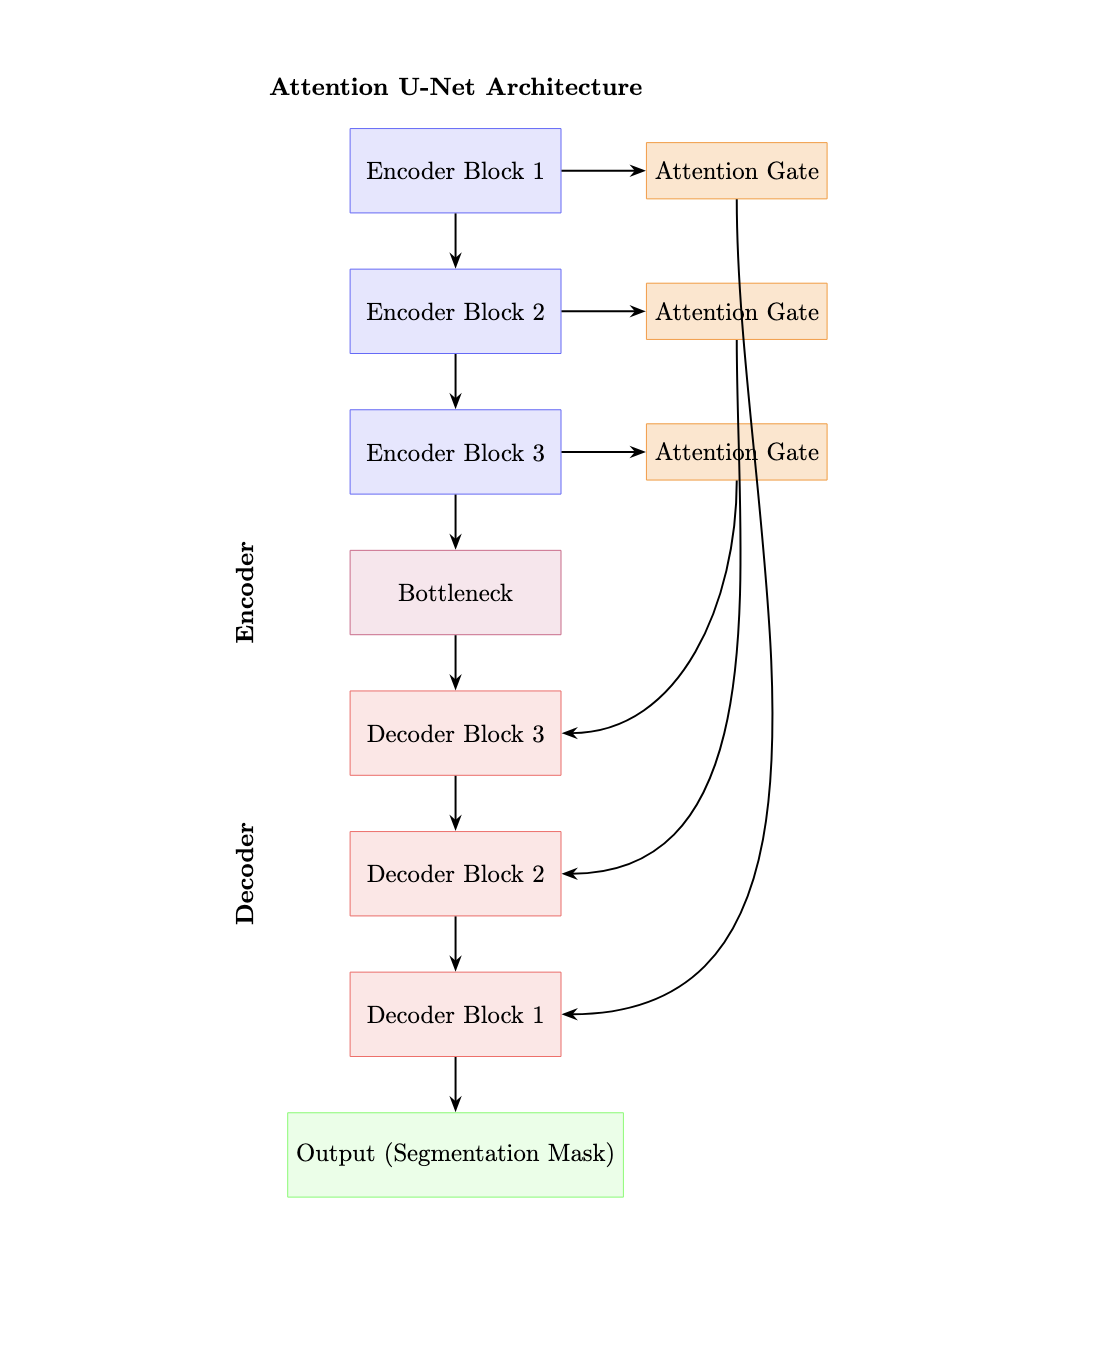

#### 3.1 Define attention gate
Implement the attention gate used to refine skip connections in the Attention U-Net.

In [7]:
# Attention Gate
def attention_gate(x, g, inter_shape):
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(g)
    add = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi = layers.Conv2D(1, (1, 1), padding='same')(add)
    psi = layers.Activation('sigmoid')(psi)
    upsample_psi = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(psi)
    return layers.multiply([x, upsample_psi])


#### 3.2 Build Attention U-Net architecture
 Define the full architecture of the Attention U-Net for binary segmentation.


In [8]:
# Lighter Attention U-Net
def attention_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)

    # Contracting path (ENCODER)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bridge
    bn = layers.Conv2D(512, 3, activation='relu', padding='same')(p4)
    bn = layers.Conv2D(512, 3, activation='relu', padding='same')(bn)

    # Expansive path (DECODER)
    g4 = attention_gate(c4, bn, 256)
    u4 = layers.concatenate([layers.UpSampling2D()(bn), g4])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    g3 = attention_gate(c3, c5, 128)
    u3 = layers.concatenate([layers.UpSampling2D()(c5), g3])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    g2 = attention_gate(c2, c6, 64)
    u2 = layers.concatenate([layers.UpSampling2D()(c6), g2])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    g1 = attention_gate(c1, c7, 32)
    u1 = layers.concatenate([layers.UpSampling2D()(c7), g1])
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c8)
    return models.Model(inputs, outputs)


### 4. Metrics
#### 4.1 Define thresholded IoU metric
 Create a custom Intersection-over-Union (IoU) metric with thresholding for segmentation evaluation.


In [9]:
# Correct metric: apply threshold before IoU
def thresholded_mean_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    return tf.keras.metrics.MeanIoU(num_classes=2)(y_true, y_pred)


#### 4.2 Initialize and reset MeanIoU metric
 Instantiate MeanIoU from Keras globally to be used during evaluation.


In [11]:
# Create MeanIoU object globally
mean_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)

# Define thresholded metric function
def thresholded_mean_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    mean_iou_metric.reset_state()   # Reset before use
    mean_iou_metric.update_state(y_true, y_pred)
    
    return mean_iou_metric.result()


### 5. Model Compilation and Training
#### 5.1 Compile the model
 Compile the model with the Adam optimizer, binary crossentropy loss, and the custom IoU metric.


In [12]:
model.compile(optimizer='adam',
              loss=losses.BinaryCrossentropy(),
              metrics=[thresholded_mean_iou])


#### 5.2 Train the model
Fit the model on the training data with validation, using a fixed number of epochs.


In [13]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=30,
                    batch_size=8)


Epoch 1/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 581s 2s/step - loss: 0.2299 - thresholded_mean_iou: 0.5277 - val_loss: 0.0128 - val_thresholded_mean_iou: 0.5304
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - loss: 0.0132 - thresholded_mean_iou: 0.5195 - val_loss: 0.0147 - val_thresholded_mean_iou: 0.5304
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 880s 2s/step - loss: 0.0118 - thresholded_mean_iou: 0.5483 - val_loss: 0.0085 - val_thresholded_mean_iou: 0.6476
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - loss: 0.0100 - thresholded_mean_iou: 0.6077 - val_loss: 0.0072 - val_thresholded_mean_iou: 0.7115
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 977s 3s/step - loss: 0.0064 - thresholded_mean_iou: 0.7366 - val_loss: 0.0051 - val_thresholded_mean_iou: 0.7974
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - loss: 0.0048 - thresholded_mean_iou: 0.8002 - val_loss: 0.0040 - val_thresholded_mean_iou: 0.8350
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 880s 2s/step - loss: 0.0032 - thresholded_

### 6. Model Saving
#### 6.1 Save model weights
Save the final model (architecture + weights) to disk for future use or inference.


In [15]:
import os
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

model.save_weights('saved_models/attention_unet_final_mac.weights.h5')
print("✅ Model saved successfully!")


✅ Model saved successfully!


#### 6.2 Save full model


In [19]:
model.save('saved_models/attention_unet_final_mac.keras')
print("✅ Full model saved (architecture + weights)!")


✅ Full model saved (architecture + weights)!


### 7. Evaluation and Visualization
#### 7.1 Plot training history (loss and IoU)
Plot the training and validation loss and IoU metrics over epochs to assess performance.


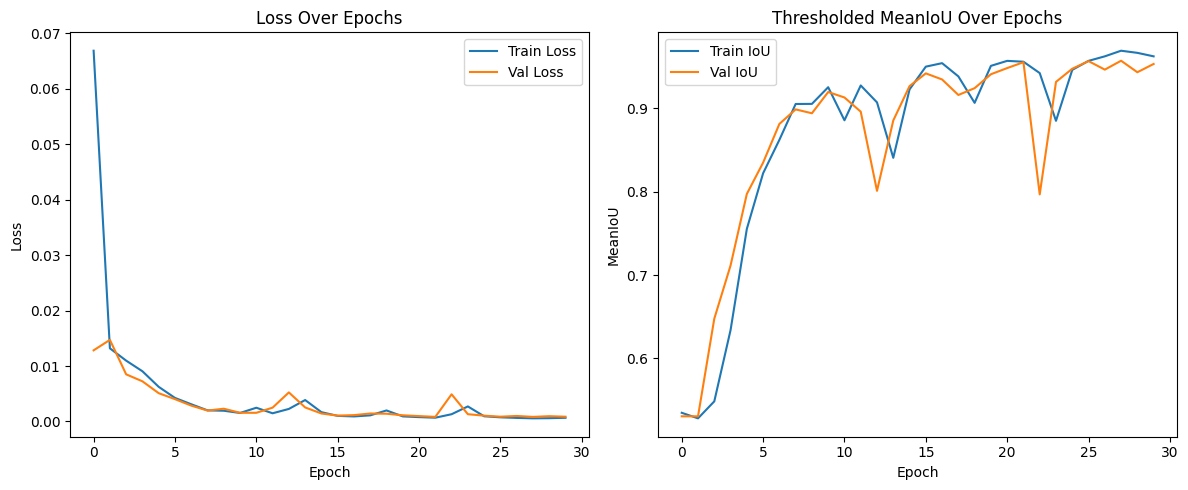

In [16]:
# Plot Loss History
plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Thresholded MeanIoU
plt.subplot(1,2,2)
plt.plot(history.history['thresholded_mean_iou'], label='Train IoU')
plt.plot(history.history['val_thresholded_mean_iou'], label='Val IoU')
plt.title('Thresholded MeanIoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MeanIoU')
plt.legend()

plt.tight_layout()
plt.show()


#### 7.2 Visualize predictions (input, GT, prediction)
Import libraries required for sampling and visualizing predictions.
Plot predictions alongside ground truth to visually assess segmentation quality.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


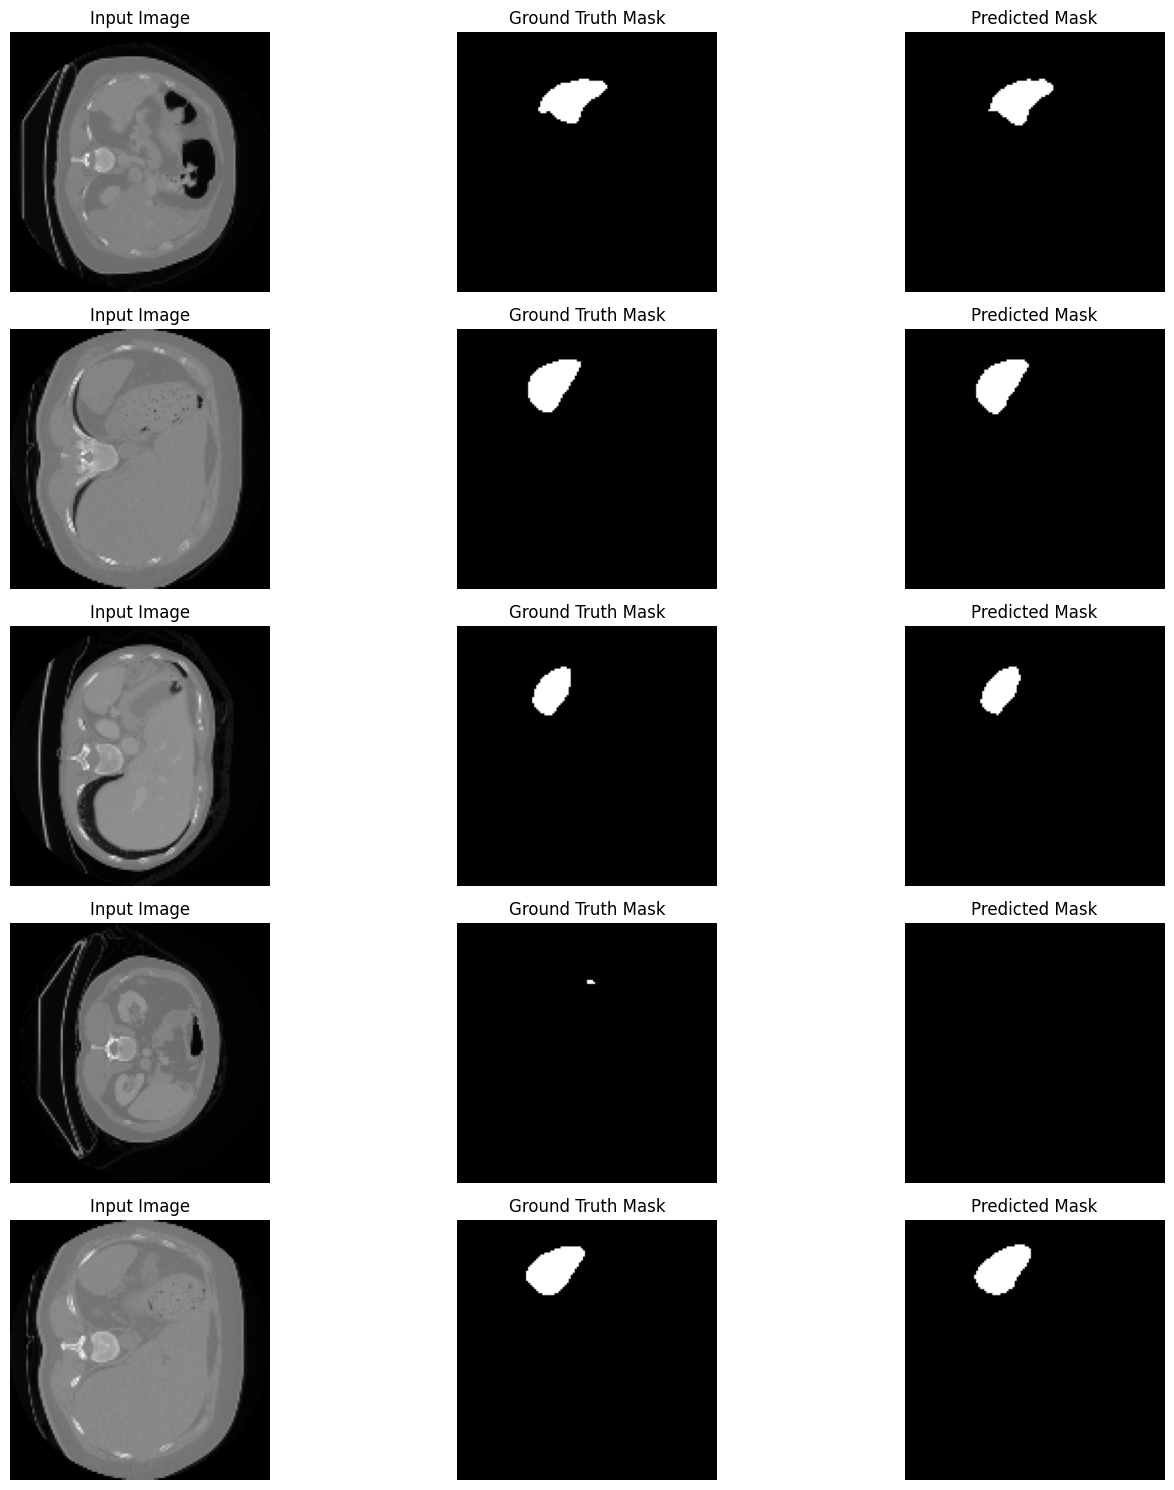

In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt

def visualize_predictions_nonempty(model, X_val, Y_val, num_samples=5):
    # Find indices where Ground Truth mask is NOT empty
    non_empty_indices = [i for i in range(Y_val.shape[0]) if np.sum(Y_val[i]) > 0]

    # Randomly select some non-empty samples
    selected_indices = random.sample(non_empty_indices, min(num_samples, len(non_empty_indices)))

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(selected_indices):
        img = X_val[idx]
        true_mask = Y_val[idx]
        pred_mask = model.predict(img[np.newaxis, ...])[0]
        pred_mask_thresholded = (pred_mask > 0.5).astype(np.float32)

        # Plot
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(pred_mask_thresholded.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the new function
visualize_predictions_nonempty(model, X_val, Y_val, num_samples=5)


#### 7.3 Overlay prediction vs. ground truth on input image
Plot random predictions alongside ground truth to visually assess segmentation quality.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


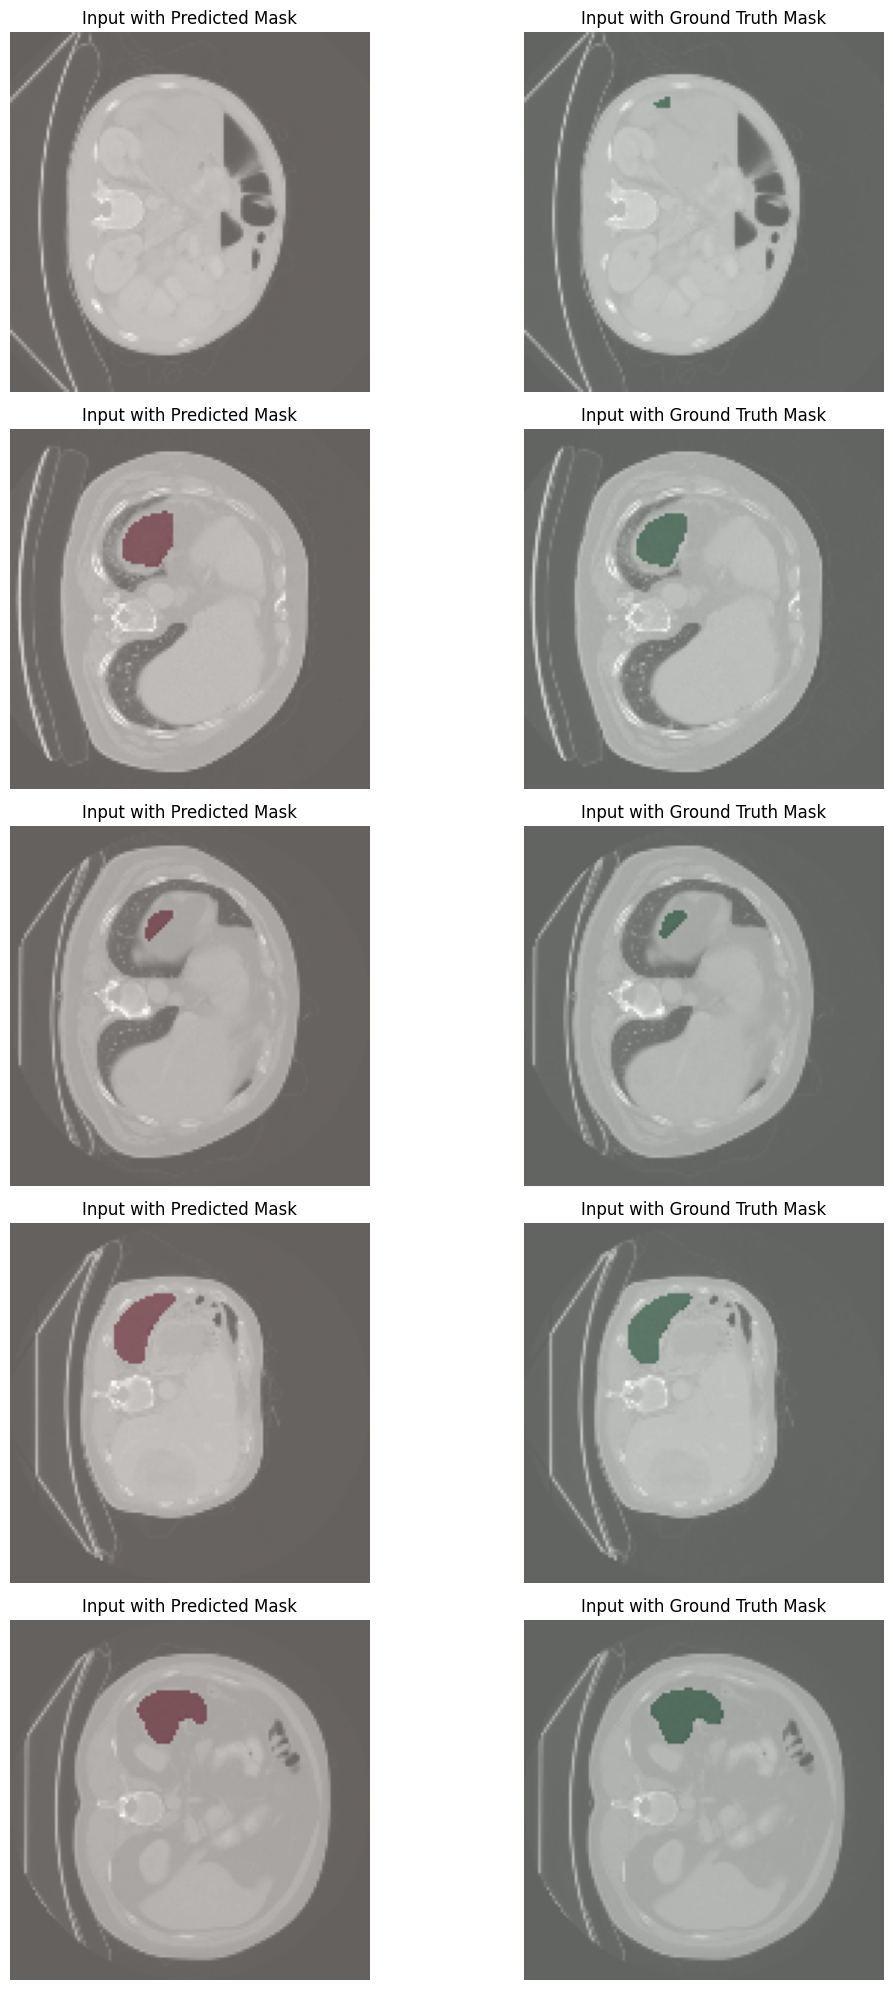

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random

def blend_prediction_with_image(model, X_val, Y_val, num_samples=5):
    non_empty_indices = [i for i in range(Y_val.shape[0]) if np.sum(Y_val[i]) > 0]
    selected_indices = random.sample(non_empty_indices, min(num_samples, len(non_empty_indices)))

    plt.figure(figsize=(12, num_samples * 4))

    for i, idx in enumerate(selected_indices):
        img = X_val[idx].squeeze()
        true_mask = Y_val[idx].squeeze()
        pred_mask = model.predict(img[np.newaxis, ..., np.newaxis])[0].squeeze()
        pred_mask_thresholded = (pred_mask > 0.5).astype(np.float32)

        # Plot Input + Prediction Overlay
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_mask_thresholded, cmap='Reds', alpha=0.4)  # Red overlay, 40% transparent
        plt.title('Input with Predicted Mask')
        plt.axis('off')

        # Plot Input + Ground Truth Overlay
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(img, cmap='gray')
        plt.imshow(true_mask, cmap='Greens', alpha=0.4)  # Green overlay, 40% transparent
        plt.title('Input with Ground Truth Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run it!
blend_prediction_with_image(model, X_val, Y_val, num_samples=5)


#### 7.4 Save blended visualization images


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

def blend_prediction_with_image_and_save(model, X_val, Y_val, save_dir='saved_visualizations', num_samples=5):
    # Create folder if not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    non_empty_indices = [i for i in range(Y_val.shape[0]) if np.sum(Y_val[i]) > 0]
    selected_indices = random.sample(non_empty_indices, min(num_samples, len(non_empty_indices)))

    for i, idx in enumerate(selected_indices):
        img = X_val[idx].squeeze()
        true_mask = Y_val[idx].squeeze()
        pred_mask = model.predict(img[np.newaxis, ..., np.newaxis])[0].squeeze()
        pred_mask_thresholded = (pred_mask > 0.5).astype(np.float32)

        # Create a figure
        plt.figure(figsize=(8, 4))

        # Predicted Mask overlay
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_mask_thresholded, cmap='Reds', alpha=0.4)
        plt.title('Input with Predicted Mask')
        plt.axis('off')

        # Ground Truth Mask overlay
        plt.subplot(1, 2, 2)
        plt.imshow(img, cmap='gray')
        plt.imshow(true_mask, cmap='Greens', alpha=0.4)
        plt.title('Input with Ground Truth Mask')
        plt.axis('off')

        plt.tight_layout()

        # Save figure
        save_path = os.path.join(save_dir, f'visualization_{i}.png')
        plt.savefig(save_path)
        plt.close()

    print(f"✅ Saved {num_samples} visualization images inside '{save_dir}' folder!")


blend_prediction_with_image_and_save(model, X_val, Y_val, save_dir='saved_visualizations', num_samples=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
✅ Saved 5 visualization images inside 'saved_visualizations' folder!


## FUTURE WORK

I would like to continue working on this project beyond its current scope. So far, I’ve used 2D slices of size 128×128, but a natural next step would be to train the model with higher-resolution images (e.g., 256×256) to preserve more anatomical detail.
Additionally, I'm interested in exploring 3D Attention U-Net architectures, which process entire volumes instead of individual slices  allowing the model to better understand spatial continuity across the body.

This work has strong clinical potential, and I'm excited to keep improving its performance and robustness toward real-world medical use.